<a href="https://colab.research.google.com/github/hatttruong/machine-learning-from-scratch/blob/master/notebooks/explore_gradient_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I implement some functions to understanding more about gradient boosting based on the blog explained.ai

Ref: https://explained.ai/gradient-boosting/index.html

In [129]:
import pandas as pd
import numpy as np
from sklearn.metrics import *

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

## Regression tree stump

According to Wiki:

A **decision stump** is a machine learning model consisting of a **one-level** decision tree. That is, it is a decision tree with one internal node (the root) which is immediately connected to the terminal nodes (its leaves). A decision stump makes a prediction based on the value of just a single input feature. Sometimes they are also called **1-rules**

In [1]:
def regression_decision_stump(x, y, verbose=False):
    df_temp = pd.DataFrame({'x': x, 'y': y}).sort_values(by='x')

    # finding the best split
    min_var = None
    split = None
    mean_left = None
    mean_right = None
    for i in range(0, len(x) - 1):
        left = df_temp.loc[:i, 'y'].to_list()
        right = df_temp.loc[i + 1:, 'y'].to_list()
        var_left = np.var(left)
        var_right = np.var(right)
        var = (var_left + var_right) / 2
        if verbose:
            print(f'\niter: {i}')
            print(f'left: {left}')
            print(f'right: {right}')
            print(f'var_left={var_left}, var_right={var_right}, var={var}')
        if min_var is None or (min_var is not None and min_var > var):
            split = df_temp.loc[i, 'x'] + (df_temp.loc[i + 1, 'x'] - df_temp.loc[i, 'x']) * 1.0 / 2
            mean_left = np.mean(left)
            mean_right = np.mean(right)
            min_var = var
            if verbose:
                print(f'split={split}, min_var={min_var}')

    return split, mean_left, mean_right

# Gradient boosting: Distance to target

In this example, the weak models trained regression tree stumps on residual vector

In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.DataFrame(
    {'sqfeet': [750, 800, 850, 900, 950],
     'rent': [1160, 1200, 1280, 1450, 2000]})
df.head()

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,2000


In [4]:
df = pd.DataFrame(
    [(750, 1160), (800, 1200), (850, 1280), (900, 1450), (950, 2000)],
    columns=['sqfeet', 'rent']
    )
df.head()

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,2000


### F_0

In [5]:
N = df.shape[0]
# F0 is average of rent
df['F_0'] = [df.rent.sum() * 1.0 / N] * N
df.head()

,sqfeet,rent,F_0
0,750,1160,1418.0
1,800,1200,1418.0
2,850,1280,1418.0
3,900,1450,1418.0
4,950,2000,1418.0


In [6]:
df['residual_0'] = df.rent - df.F_0
df.head()

,sqfeet,rent,F_0,residual_0
0,750,1160,1418.0,-258.0
1,800,1200,1418.0,-218.0
2,850,1280,1418.0,-138.0
3,900,1450,1418.0,32.0
4,950,2000,1418.0,582.0


### F_n

In [7]:
verbose = True
M = 3
N = df.shape[0]
learning_rate = 1.0

result = []
for i in range(1, M + 1):
    if verbose:
        print(f'\nIter {i}:')
    # weak_i
    s, l, r = regression_decision_stump(df.sqfeet.to_list(), df[f'residual_{i-1}'].to_list())
    if verbose:
        print(s, l, r)
    df[f'weak_{i}'] = np.where(df.sqfeet < s, l, r)
    #
    # F_i
    df[f'F_{i}'] = df[f'F_{i-1}'] + learning_rate * df[f'weak_{i}']
    #
    # residual_i
    df[f'residual_{i}'] = df.rent - df[f'F_{i}']
    #
    # mse
    mse = mean_squared_error(df.rent, df[f'F_{i}'])
    print('mse=', mse)
    result.append((learning_rate, i, mse))
df.head()


Iter 1:
925.0 -145.5 582.0
mse= 9895.0

Iter 2:
825.0 -92.5 61.666666666666664
mse= 4190.833333333328

Iter 3:
925.0 15.416666666666629 -61.666666666666515
mse= 3240.1388888888855


,sqfeet,rent,F_0,residual_0,weak_1,F_1,residual_1,weak_2,F_2,residual_2,weak_3,F_3,residual_3
0,750,1160,1418.0,-258.0,-145.5,1272.5,-112.5,-92.500000,1180.000000,-20.000000,15.416667,1195.416667,-35.416667
1,800,1200,1418.0,-218.0,-145.5,1272.5,-72.5,-92.500000,1180.000000,20.000000,15.416667,1195.416667,4.583333
2,850,1280,1418.0,-138.0,-145.5,1272.5,7.5,61.666667,1334.166667,-54.166667,15.416667,1349.583333,-69.583333
3,900,1450,1418.0,32.0,-145.5,1272.5,177.5,61.666667,1334.166667,115.833333,15.416667,1349.583333,100.416667
4,950,2000,1418.0,582.0,582.0,2000.0,0.0,61.666667,2061.666667,-61.666667,-61.666667,2000.000000,0.000000


In [8]:
df_mse = pd.DataFrame(result, columns=['learning_rate', 'i', 'mse'])
df_mse.head()

,learning_rate,i,mse
0,1.0,1,9895.000000
1,1.0,2,4190.833333
2,1.0,3,3240.138889


### F_1

In [9]:
s, l, r = regression_decision_stump(df.sqfeet.to_list(), df.residual_0.to_list())
print(s, l, r)
df['weak_1'] = np.where(df.sqfeet < s, l, r)
df.head()

925.0 -145.5 582.0


,sqfeet,rent,F_0,residual_0,weak_1,F_1,residual_1,weak_2,F_2,residual_2,weak_3,F_3,residual_3
0,750,1160,1418.0,-258.0,-145.5,1272.5,-112.5,-92.500000,1180.000000,-20.000000,15.416667,1195.416667,-35.416667
1,800,1200,1418.0,-218.0,-145.5,1272.5,-72.5,-92.500000,1180.000000,20.000000,15.416667,1195.416667,4.583333
2,850,1280,1418.0,-138.0,-145.5,1272.5,7.5,61.666667,1334.166667,-54.166667,15.416667,1349.583333,-69.583333
3,900,1450,1418.0,32.0,-145.5,1272.5,177.5,61.666667,1334.166667,115.833333,15.416667,1349.583333,100.416667
4,950,2000,1418.0,582.0,582.0,2000.0,0.0,61.666667,2061.666667,-61.666667,-61.666667,2000.000000,0.000000


In [10]:
df['F_1'] = df.F_0 + df.weak_1
df.head()

,sqfeet,rent,F_0,residual_0,weak_1,F_1,residual_1,weak_2,F_2,residual_2,weak_3,F_3,residual_3
0,750,1160,1418.0,-258.0,-145.5,1272.5,-112.5,-92.500000,1180.000000,-20.000000,15.416667,1195.416667,-35.416667
1,800,1200,1418.0,-218.0,-145.5,1272.5,-72.5,-92.500000,1180.000000,20.000000,15.416667,1195.416667,4.583333
2,850,1280,1418.0,-138.0,-145.5,1272.5,7.5,61.666667,1334.166667,-54.166667,15.416667,1349.583333,-69.583333
3,900,1450,1418.0,32.0,-145.5,1272.5,177.5,61.666667,1334.166667,115.833333,15.416667,1349.583333,100.416667
4,950,2000,1418.0,582.0,582.0,2000.0,0.0,61.666667,2061.666667,-61.666667,-61.666667,2000.000000,0.000000


In [11]:
df['residual_1'] = df.rent - df.F_1
df.head()

,sqfeet,rent,F_0,residual_0,weak_1,F_1,residual_1,weak_2,F_2,residual_2,weak_3,F_3,residual_3
0,750,1160,1418.0,-258.0,-145.5,1272.5,-112.5,-92.500000,1180.000000,-20.000000,15.416667,1195.416667,-35.416667
1,800,1200,1418.0,-218.0,-145.5,1272.5,-72.5,-92.500000,1180.000000,20.000000,15.416667,1195.416667,4.583333
2,850,1280,1418.0,-138.0,-145.5,1272.5,7.5,61.666667,1334.166667,-54.166667,15.416667,1349.583333,-69.583333
3,900,1450,1418.0,32.0,-145.5,1272.5,177.5,61.666667,1334.166667,115.833333,15.416667,1349.583333,100.416667
4,950,2000,1418.0,582.0,582.0,2000.0,0.0,61.666667,2061.666667,-61.666667,-61.666667,2000.000000,0.000000


### F_2

In [12]:
s, l, r = regression_decision_stump(df.sqfeet.to_list(), df.residual_1.to_list(),
                                    verbose=False)
print(s, l, r)
df['weak_2'] = np.where(df.sqfeet < s, l, r)
df.head()

825.0 -92.5 61.666666666666664


,sqfeet,rent,F_0,residual_0,weak_1,F_1,residual_1,weak_2,F_2,residual_2,weak_3,F_3,residual_3
0,750,1160,1418.0,-258.0,-145.5,1272.5,-112.5,-92.500000,1180.000000,-20.000000,15.416667,1195.416667,-35.416667
1,800,1200,1418.0,-218.0,-145.5,1272.5,-72.5,-92.500000,1180.000000,20.000000,15.416667,1195.416667,4.583333
2,850,1280,1418.0,-138.0,-145.5,1272.5,7.5,61.666667,1334.166667,-54.166667,15.416667,1349.583333,-69.583333
3,900,1450,1418.0,32.0,-145.5,1272.5,177.5,61.666667,1334.166667,115.833333,15.416667,1349.583333,100.416667
4,950,2000,1418.0,582.0,582.0,2000.0,0.0,61.666667,2061.666667,-61.666667,-61.666667,2000.000000,0.000000


In [13]:
df['F_2'] = df.F_1 + df.weak_2
df.head()

,sqfeet,rent,F_0,residual_0,weak_1,F_1,residual_1,weak_2,F_2,residual_2,weak_3,F_3,residual_3
0,750,1160,1418.0,-258.0,-145.5,1272.5,-112.5,-92.500000,1180.000000,-20.000000,15.416667,1195.416667,-35.416667
1,800,1200,1418.0,-218.0,-145.5,1272.5,-72.5,-92.500000,1180.000000,20.000000,15.416667,1195.416667,4.583333
2,850,1280,1418.0,-138.0,-145.5,1272.5,7.5,61.666667,1334.166667,-54.166667,15.416667,1349.583333,-69.583333
3,900,1450,1418.0,32.0,-145.5,1272.5,177.5,61.666667,1334.166667,115.833333,15.416667,1349.583333,100.416667
4,950,2000,1418.0,582.0,582.0,2000.0,0.0,61.666667,2061.666667,-61.666667,-61.666667,2000.000000,0.000000


In [14]:
x = df.sqfeet.to_list()
y = df.residual_0.to_list()
df_temp = pd.DataFrame({'x': x, 'y': y}).sort_values(by='x')
df_temp.head()

,x,y
0,750,-258.0
1,800,-218.0
2,850,-138.0
3,900,32.0
4,950,582.0


### Different learning rate

In [130]:
verbose = False
M = 3
N = df.shape[0]
learning_rates = [1.0, 0.9, 0.8, 0.7, 0.6]
result = []
for learning_rate in learning_rates:
    if verbose:
        print(f'\nlearning_rate {learning_rate}:')
    for i in range(1, M + 1):
        if verbose:
            print(f'\nIter {i}:')
        # weak_i
        s, l, r = regression_decision_stump(df.sqfeet.to_list(), df[f'residual_{i-1}'].to_list())
        if verbose:
            print(s, l, r)
        df[f'weak_{i}'] = np.where(df.sqfeet < s, l, r)
        #
        # F_i
        df[f'F_{i}'] = df[f'F_{i-1}'] + learning_rate * df[f'weak_{i}']
        #
        # residual_i
        df[f'residual_{i}'] = df.rent - df[f'F_{i}']
        #
        # mse
        mse = mean_squared_error(df.rent, df[f'F_{i}'])
        # mae
        mae = mean_absolute_error(df.rent, df[f'F_{i}'])
        if verbose:
            print(f'mse={mse}, mae={mae}')
        result.append((learning_rate, i, mse, mae))
df_mse = pd.DataFrame(result, columns=['learning_rate', 'i', 'mse', 'mae'])
df_mse.head(20)

,learning_rate,i,mse,mae
0,1.0,1,28939.000000,138.000000
1,1.0,2,4190.833333,54.333333
2,1.0,3,3240.138889,42.000000
3,0.9,1,29785.810000,138.000000
4,0.9,2,2862.541788,46.331000
5,0.9,3,1761.944674,37.888100
6,0.8,1,32326.240000,139.440000
7,0.8,2,2824.953600,46.309333
8,0.8,3,429.894286,19.868089
9,0.7,1,36560.290000,145.260000


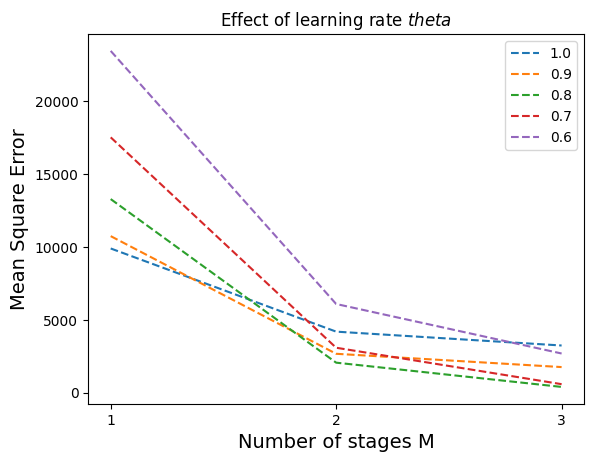

In [45]:

learning_rates = df_mse.learning_rate.unique()
for r in learning_rates:
    temp = df_mse[df_mse.learning_rate == r]
    plt.plot(temp.i, temp.mse, linestyle='--', label=str(r))
plt.xticks(np.arange(min(df_mse.i.values), max(df_mse.i.values) + 1, 1))

plt.title('Effect of learning rate $theta$')
plt.xlabel('Number of stages M', fontsize=14)
plt.ylabel('Mean Square Error', fontsize=14)
plt.legend()
plt.show()

### sklearn.ensemble.GradientBoostingRegressor

Doc: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [63]:
from sklearn.ensemble import GradientBoostingRegressor
# Because in the example we built a tree stump which has only one root node and it's leaves,
# max_depth must be set to 1 to get the same result
reg = GradientBoostingRegressor(
    loss='squared_error', learning_rate=1.0, n_estimators=3, max_depth=1,
    random_state=0)
reg.fit(X=df.sqfeet.values.reshape(-1, 1), y=df.rent)

GradientBoostingRegressor(learning_rate=1.0, max_depth=1, n_estimators=3,
                          random_state=0)

In [69]:
# print(df.sqfeet.values.shape) # (5,)
# print(df.sqfeet.values.reshape(-1, 1).shape) # (5,1)

In [65]:
reg.train_score_

array([9895.        , 4190.83333333, 3240.13888889])

In [68]:
df_mse[df_mse.learning_rate == 1.0]

,learning_rate,i,mse
0,1.0,1,9895.000000
1,1.0,2,4190.833333
2,1.0,3,3240.138889


In [66]:
reg.predict(df.sqfeet.values.reshape(-1, 1))

array([1195.41666667, 1195.41666667, 1349.58333333, 1349.58333333,
       2000.        ])

# Regression tree stump V2

In [92]:
def regression_decision_stump_median(x, sign_y, y, verbose=False):
    df_temp = pd.DataFrame({'x': x, 'sign_y': sign_y, 'y': y}).sort_values(by='x')

    # finding the best split
    min_var = None
    split = None
    median_left = None
    median_right = None
    for i in range(0, len(x) - 1):
        left = df_temp.loc[:i, 'sign_y'].to_list()
        right = df_temp.loc[i + 1:, 'sign_y'].to_list()
        var_left = np.var(left)
        var_right = np.var(right)
        var = (var_left + var_right) / 2
        if verbose:
            print(f'\niter: {i}')
            print(f'left: {left}')
            print(f'right: {right}')
            print(f'var_left={var_left}, var_right={var_right}, var={var}')
        if min_var is None or (min_var is not None and min_var > var):
            split = df_temp.loc[i, 'x'] + (df_temp.loc[i + 1, 'x'] - df_temp.loc[i, 'x']) * 1.0 / 2
            median_left = np.median(df_temp.loc[:i, 'y'].to_list())
            median_right = np.median(df_temp.loc[i + 1:, 'y'].to_list())
            min_var = var
            if verbose:
                print(f'split={split}, min_var={min_var}')

    return split, median_left, median_right

# Gradient boosting: Heading in the Right Direction

In this example, the weak models trained regression tree stumps on the sign of vector

In [123]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

sign = lambda x: 1 if x > 0 else -1 if x < 0 else 0

In [103]:

df_sign = pd.DataFrame(
    {'sqfeet': [750, 800, 850, 900, 950],
     'rent': [1160, 1200, 1280, 1450, 2000]})
df_sign.head()

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,2000


### F_0

In [109]:
N = df_sign.shape[0]
learning_rate = 1.0
df_sign['F_0'] = [np.median(df_sign.rent)] * N
df_sign.head()

,sqfeet,rent,F_0,residual_0,sign_0,weak_1,F_1,residual_1,sign_1
0,750,1160,1280.0,-120.0,-1,-100.0,1220.0,-60.0,-1
1,800,1200,1280.0,-80.0,-1,-100.0,1220.0,-20.0,-1
2,850,1280,1280.0,0.0,0,170.0,1382.0,-102.0,-1
3,900,1450,1280.0,170.0,1,170.0,1382.0,68.0,1
4,950,2000,1280.0,720.0,1,170.0,1382.0,618.0,1


In [110]:
df_sign['residual_0'] = df_sign.rent - df_sign.F_0
df_sign['sign_0'] = df_sign['residual_0'].apply(lambda x: sign(x))
df_sign.head()

,sqfeet,rent,F_0,residual_0,sign_0,weak_1,F_1,residual_1,sign_1
0,750,1160,1280.0,-120.0,-1,-100.0,1220.0,-60.0,-1
1,800,1200,1280.0,-80.0,-1,-100.0,1220.0,-20.0,-1
2,850,1280,1280.0,0.0,0,170.0,1382.0,-102.0,-1
3,900,1450,1280.0,170.0,1,170.0,1382.0,68.0,1
4,950,2000,1280.0,720.0,1,170.0,1382.0,618.0,1


### F_1


In [111]:
s, l, r = regression_decision_stump_median(
    x=df_sign.sqfeet.to_list(), sign_y=df_sign.sign_0,
    y=df_sign.residual_0.to_list(), verbose=True)
print(s, l, r)
df_sign['weak_1'] = np.where(df.sqfeet < s, l, r)
df_sign.head()


iter: 0
left: [-1]
right: [-1, 0, 1, 1]
var_left=0.0, var_right=0.6875, var=0.34375
split=775.0, min_var=0.34375

iter: 1
left: [-1, -1]
right: [0, 1, 1]
var_left=0.0, var_right=0.22222222222222224, var=0.11111111111111112
split=825.0, min_var=0.11111111111111112

iter: 2
left: [-1, -1, 0]
right: [1, 1]
var_left=0.22222222222222224, var_right=0.0, var=0.11111111111111112

iter: 3
left: [-1, -1, 0, 1]
right: [1]
var_left=0.6875, var_right=0.0, var=0.34375
825.0 -100.0 170.0


,sqfeet,rent,F_0,residual_0,sign_0,weak_1,F_1,residual_1,sign_1
0,750,1160,1280.0,-120.0,-1,-100.0,1220.0,-60.0,-1
1,800,1200,1280.0,-80.0,-1,-100.0,1220.0,-20.0,-1
2,850,1280,1280.0,0.0,0,170.0,1382.0,-102.0,-1
3,900,1450,1280.0,170.0,1,170.0,1382.0,68.0,1
4,950,2000,1280.0,720.0,1,170.0,1382.0,618.0,1


In [108]:
learning_rate

0.6

In [112]:
df_sign['F_1'] = df_sign['F_0'] + learning_rate * df_sign['weak_1']
df_sign['residual_1'] = df_sign.rent - df_sign['F_1']
df_sign['sign_1'] = df_sign['residual_1'].apply(lambda x: sign(x))
df_sign.head()

,sqfeet,rent,F_0,residual_0,sign_0,weak_1,F_1,residual_1,sign_1
0,750,1160,1280.0,-120.0,-1,-100.0,1180.0,-20.0,-1
1,800,1200,1280.0,-80.0,-1,-100.0,1180.0,20.0,1
2,850,1280,1280.0,0.0,0,170.0,1450.0,-170.0,-1
3,900,1450,1280.0,170.0,1,170.0,1450.0,0.0,0
4,950,2000,1280.0,720.0,1,170.0,1450.0,550.0,1


## F_n

In [119]:
M = 3
learning_rate = 1.0
for i in range(1, M + 1):
    print(f'\nIter: {i}')
    s, l, r = regression_decision_stump_median(
        x=df_sign.sqfeet.to_list(), sign_y=df_sign[f'sign_{i-1}'],
        y=df_sign[f'residual_{i-1}'].to_list())
    print(s, l, r)

    df_sign[f'weak_{i}'] = np.where(df.sqfeet < s, l, r)
    df_sign[f'F_{i}'] = df_sign[f'F_{i-1}'] + learning_rate * df_sign[f'weak_{i}']
    df_sign[f'residual_{i}'] = df_sign.rent - df_sign[f'F_{i}']
    df_sign[f'sign_{i}'] = df_sign[f'residual_{i}'].apply(lambda x: sign(x))

df_sign.head()


Iter: 1
825.0 -100.0 170.0

Iter: 2
775.0 -20.0 10.0

Iter: 3
925.0 -5.0 540.0


,sqfeet,rent,F_0,residual_0,sign_0,weak_1,F_1,residual_1,sign_1,weak_2,F_2,residual_2,sign_2,weak_3,F_3,residual_3,sign_3
0,750,1160,1280.0,-120.0,-1,-100.0,1180.0,-20.0,-1,-20.0,1160.0,0.0,0,-5.0,1155.0,5.0,1
1,800,1200,1280.0,-80.0,-1,-100.0,1180.0,20.0,1,10.0,1190.0,10.0,1,-5.0,1185.0,15.0,1
2,850,1280,1280.0,0.0,0,170.0,1450.0,-170.0,-1,10.0,1460.0,-180.0,-1,-5.0,1455.0,-175.0,-1
3,900,1450,1280.0,170.0,1,170.0,1450.0,0.0,0,10.0,1460.0,-10.0,-1,-5.0,1455.0,-5.0,-1
4,950,2000,1280.0,720.0,1,170.0,1450.0,550.0,1,10.0,1460.0,540.0,1,540.0,2000.0,0.0,0


## Different learning rate

In [125]:
verbose = False
M = 3
N = df_sign.shape[0]
learning_rates = [1.0, 0.9, 0.8, 0.7, 0.6]
result = []
for learning_rate in learning_rates:
    if verbose:
        print(f'\nlearning_rate {learning_rate}:')
    for i in range(1, M + 1):
        if verbose:
            print(f'\nIter {i}:')
        s, l, r = regression_decision_stump_median(
            x=df_sign.sqfeet.to_list(), sign_y=df_sign[f'sign_{i-1}'],
            y=df_sign[f'residual_{i-1}'].to_list())
        if verbose: print(s, l, r)

        df_sign[f'weak_{i}'] = np.where(df_sign.sqfeet < s, l, r)
        df_sign[f'F_{i}'] = df_sign[f'F_{i-1}'] + learning_rate * df_sign[f'weak_{i}']
        df_sign[f'residual_{i}'] = df_sign.rent - df_sign[f'F_{i}']
        df_sign[f'sign_{i}'] = df_sign[f'residual_{i}'].apply(lambda x: sign(x))
        #
        # mae
        mae = mean_absolute_error(df_sign.rent, df_sign[f'F_{i}'])
        if verbose:
            print(f'mae={mae}')
        result.append((learning_rate, i, mae))
df_mae = pd.DataFrame(result, columns=['learning_rate', 'i', 'mae'])
df_mae.head(20)

,learning_rate,i,mae
0,1.0,1,152.000
1,1.0,2,148.000
2,1.0,3,40.000
3,0.9,1,155.400
4,0.9,2,146.000
5,0.9,3,142.660
6,0.8,1,158.800
7,0.8,2,138.800
8,0.8,3,81.712
9,0.7,1,166.200


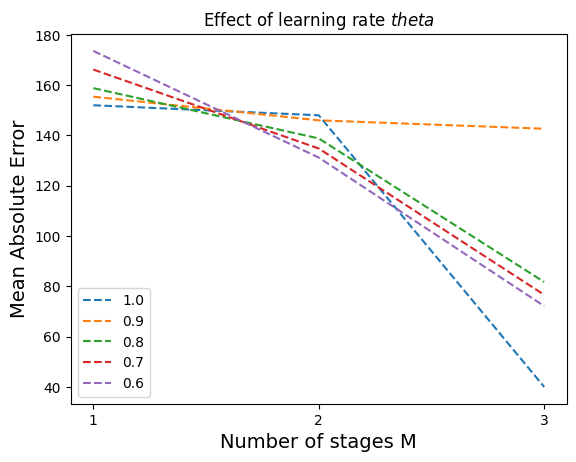

In [126]:

learning_rates = df_mae.learning_rate.unique()
for r in learning_rates:
    temp = df_mae[df_mae.learning_rate == r]
    plt.plot(temp.i, temp.mae, linestyle='--', label=str(r))
plt.xticks(np.arange(min(df_mae.i.values), max(df_mae.i.values) + 1, 1))

plt.title('Effect of learning rate $theta$')
plt.xlabel('Number of stages M', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.legend()
plt.show()

## Using Sklearn

[TODO] have not mimic the method that we train on the sign of $y - \hat_y$ instead of residual

In [133]:
from sklearn.ensemble import GradientBoostingRegressor
# Because in the example we built a tree stump which has only one root node and it's leaves,
# max_depth must be set to 1 to get the same result
reg = GradientBoostingRegressor(
    loss='absolute_error', criterion='squared_error', learning_rate=1.0, n_estimators=3, max_depth=1,
    random_state=0)
reg.fit(X=df.sqfeet.values.reshape(-1, 1), y=df.rent)

GradientBoostingRegressor(criterion='squared_error', learning_rate=1.0,
                          loss='absolute_error', max_depth=1, n_estimators=3,
                          random_state=0)

In [135]:
reg.train_score_

array([134., 118.,  24.])